In [1]:
# Two issues

# 1) Weird low-frequency artifacts when masking with square masks
# 2) Still missing the fainter points

# To remedy this, I'm going to try to look for bright spots in constrained areas
# Calculate lattice statistics on the new spots found (filtering out some of the spots under stringent criteria)
# But return the indices of all points picked up on the secondpass + firstpass for masking

# I'm also going to restructure find_lattice and the while loop in mask_image...it's a mess.

# Finally, I'm going to code a switch into mask_image to specify whether it's going to look for a lattice at all.

# So let's use this script to develop a new version of mask_image and find_lattice.

In [26]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import os
from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdsec_opened
from itertools import product
plt.rcParams['figure.figsize'] = [10, 10]

In [27]:
import numpy as np
import scipy.fft as sfft
import matplotlib.pyplot as plt
import time
import multiprocessing
import os

In [28]:
threshold_method='sd' 
pixel_size = 1.048
verbose=True
show_plots=True
threads=16
sigma=9
num_sd=5
num_sd_secondpass=1.5
x_window_percent=(0.002, 0.95)
y_window_percent=(0, 1)
miller_index_buffer=10
box_radius=5
min_lattice_size=3
epsilon=0.0707
mask_hotpixels=False
mask_radius=3
replace_angle=30
return_spots=False
return_stats=False
return_image=False

filename = 'test_data/test_lattice.mrc'
filename_out = 'test_data/test_lattice_masked.mrc'

In [29]:
# Add/Eliminate parameters from this list as needed

# Old
pixel_size = 1.048
verbose=True
show_plots=True
threads=16
gaussian_smoothing=9
num_sd=5
num_sd_secondpass=1.5
x_window_fraction=(0.002, 0.95)
y_window_fraction=(0, 1)
box_radius=5
min_lattice_size=3
epsilon=0.0707
replace_angle=30
return_spots=False
return_stats=False
return_image=False

# New

find_lattice=True
mask_along_lattice=True

In [30]:
# Mask image

# Import the image
image, header = sax.import_mrc(filename)

# Perform an FFT of the image
padded_fft = sax.scipy_fft(image, verbose, threads)

# Subtract the FFT from a Gaussian-smoothed FFT,
# Smooth again to distribute extremely high intensities to neighbouring points
# But save the original intensities for lattice weighting
log_diff_spectrum, smoothed_spectrum, amplitude_spectrum = sax.generate_diff_spectrum(padded_fft, gaussian_smoothing)

# Find spots that exceed the threshold
indices, amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, amplitude_spectrum, num_sd, x_window_fraction, y_window_fraction)

scipy_fft(): FFT performed in 89.31 milliseconds.


In [31]:
# If lattice-finding is off, just mask the points and return
if not find_lattice:
    # Replace the diffraction spots
    masked_fft = sax.replace_diffraction_spots(padded_fft, indices, smoothed_spectrum, replace_angle)
    # Perform the inverse FFT
    padded_masked_image = sax.scipy_inverse_fft(masked_fft, verbose, threads)
    # Extract the original image from the padded inverse FFT
    masked_image = sax.unpad_image(padded_masked_image, image.shape)
    # Export the image as an .mrc file
    sax.export_masked_mrc(masked_image, filename_out, verbose)
    # Print a message to indicate successful masking
    if verbose:
        print(filename + " masked as " + filename_out + " without lattice-finding.")

In [32]:
# Unwrap indices to help find lattice
unwrapped_indices = sax.unwrap_indices(indices, log_diff_spectrum)

In [33]:
# Let's put the above together find a lattice from the first-pass points.

def find_lattice(unwrapped_indices, 
                 amplitudes, 
                 pixel_size,          
                 min_lattice_size=5,
                 epsilon=0.0707,
                 show_plots=False,
                 verbose=False):
    """
    Take a list of unwrapped indices and their amplitudes from find_diffraction_spots_sd() and return the
    unwrapped indices of the detected lattice spots, the highest resolution spot of the lattice, and
    the unit cell dimensions of the lattice.
    """
    
    # Show a plot of the unwrapped indices passed to the function.
    if show_plots: 
        fig, ax = plt.subplots()
        ax.set_aspect('equal', 'box')
        ax.scatter(y = unwrapped_indices[0,:], x = unwrapped_indices[1,:], s = np.exp(amplitudes))
        plt.title("Diffraction Spots, First Pass")
        plt.show()

    # If there aren't enough indices to perform lattice-finding, return.
    if unwrapped_indices.shape[1] <= min_lattice_size:
        if verbose: print("Lattice has less than " + str(min_lattice_size) + " candidate basis vectors during first pass. Terminating function and returning input indices.")
        return indices, None, None
    
    # Estmate the basis
    best_basis, best_miller = sax.estimate_basis(unwrapped_indices, amplitudes, min_lattice_size)
    # Shorten the basis vectors
    shortened_basis, shortened_miller = sax.shorten_basis(best_basis, unwrapped_indices, verbose)
    # Filter out points not near integer Miller indices
    integer_miller = sax.filter_noninteger_miller(shortened_miller, epsilon)
    # Filter out points that have been assigned the same Miller indices
    nonredundant_miller = sax.filter_redundant_miller(integer_miller)
    # Recreate the lattice points in Fourier space
    nonredundant_lattice = np.matmul(shortened_basis, nonredundant_miller)

    # Show a plot of the estimated lattice on top of the unwrapped indices passed to the function.
    if show_plots:        
        fig, ax = plt.subplots()
        ax.set_aspect('equal', 'box')
        ax.scatter(y = unwrapped_indices[0,:], x = unwrapped_indices[1,:], s = np.exp(amplitudes), label="Diffraction Spots")
        ax.scatter(y = nonredundant_lattice[0,:], x = nonredundant_lattice[1,:], s = 2, label="Estimated Lattice")
        ax.legend(loc='best')
        plt.title("Detected Lattice, First Pass")
        plt.show()
        
    # If the nonredundant lattice has less than min_lattice_size points, return.
    if nonredundant_miller.shape[1] < min_lattice_size:
        if verbose: print("Lattice has less than " + str(min_lattice_size) + " points. Terminating function and returning input indices.")
        return indices, None, None
    
    # Refine the lattice to estimate unit cell dimensions
    refined_basis = sax.refine_basis(shortened_basis, nonredundant_miller, verbose)

    # Calculate the dimensions of the unit cell
    num_pix = np.max(log_diff_spectrum.shape)
    basis_0_length = np.sqrt(np.sum(refined_basis[:,0]**2))
    basis_1_length = np.sqrt(np.sum(refined_basis[:,1]**2))
    unit_cell_dimensions = np.round(np.array([pixel_size*num_pix/basis_0_length, pixel_size*num_pix/basis_1_length]), 2)
    
    # Print dimensions if verbose
    if verbose: print("Unit cell dimensions (A):", unit_cell_dimensions[0], unit_cell_dimensions[1])

     # Sanity check: unit cell
    if np.max(unit_cell_dimensions) > 63 or np.min(unit_cell_dimensions) < 53:
        if verbose: print("Lattice unit cell max dimension is not within 5 Angstrom of the expected for Streptavidin. Terminating function and returning input indices.")
        return indices, None, None
    
    # Calculate the resolution of the farthest lattice spot from first-pass points
    num_pix = np.max(log_diff_spectrum.shape)
    max_rad = np.max(np.sqrt((nonredundant_lattice[0,:]**2 + nonredundant_lattice[1,:]**2)))
    highest_resolution = np.round(pixel_size*num_pix/max_rad, 2)

    # Print highest resolution if verbose:
    if verbose: print("Highest resolution spot (A):", highest_resolution)
        
    # Return the lattice basis, highest resolution, and unit cell dimensions
    return shortened_basis, highest_resolution, unit_cell_dimensions

In [34]:
# We now need a function to search for new peaks. This function needs to take a basis and search spectrum in,
# It needs to know the boxes to search in (box_radius) and how sensitively to search (num_sd_secondpass),
# and will output a list of indices, which we can re-run find_lattice on.
# Let's try it below.

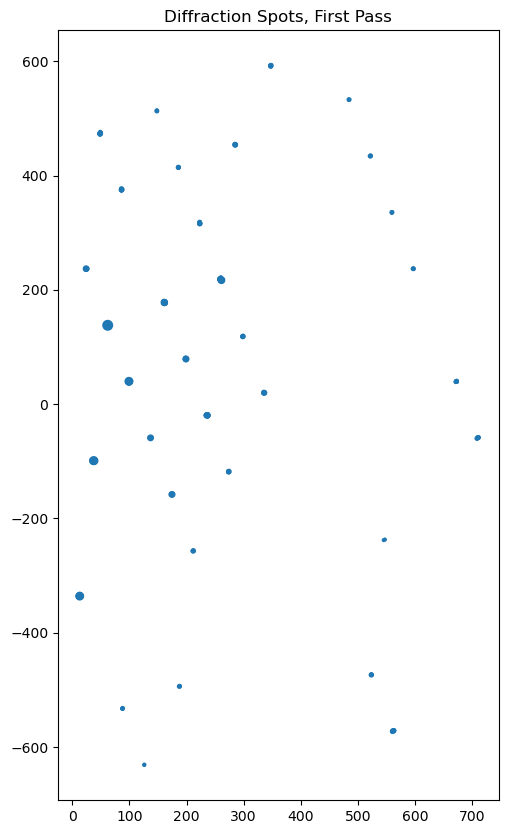

Starting basis: [[-99  40]
 [ 37  99]]
Starting basis size: 22571
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.50810358067031
[40 99] is larger than [-99  37]
The updated basis vectors are [-59 136][-99  37]
This run resulted in a basis larger than the last: 33147
Terminating loop.
------------------------------------


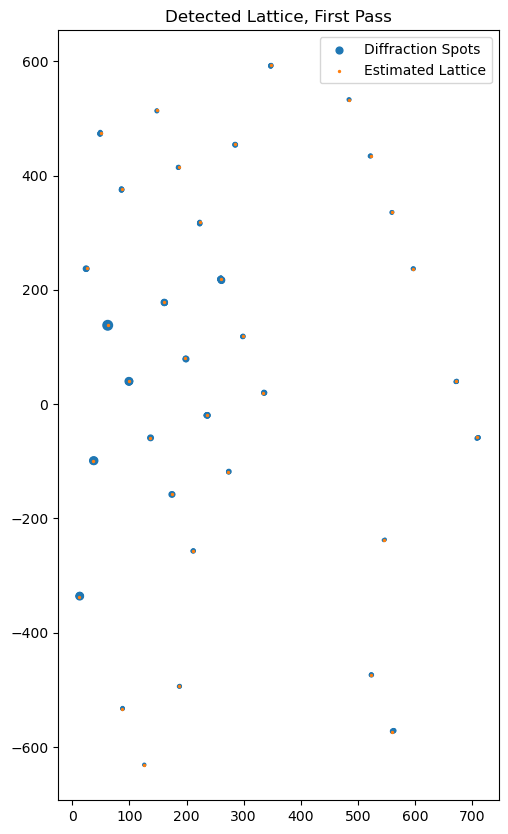

Starting basis: [[-99  40]
 [ 37  99]]
Refined_basis: [[-98.82149638  39.60987728]
 [ 37.34184312  99.31639454]]
Unit cell dimensions (A): 57.14 56.46
Highest resolution spot (A): 7.53


In [35]:
basis, highest_resolution, unit_cell_dimensions = find_lattice(unwrapped_indices, 
                                                                 amplitudes, 
                                                                 pixel_size,          
                                                                 min_lattice_size=5,
                                                                 epsilon=0.0707,
                                                                 show_plots=True,
                                                                 verbose=True)

In [36]:
# Generate the lattice points along which to search for more peaks
lattice_indices = sax.generate_lattice_indices(basis, log_diff_spectrum)

In [37]:
def find_diffraction_spots_secondpass(lattice_indices,
                                     log_diff_spectrum,
                                     box_radius=10,
                                     num_sd_secondpass=2.5,
                                     x_window_percent=(0,1),
                                     y_window_percent=(0,1)):
    
    # Define minimum and maximum indices of the window
    y_min = np.round(log_diff_spectrum.shape[0]*y_window_percent[0]).astype(int)
    y_max = np.round(log_diff_spectrum.shape[0]*y_window_percent[1]).astype(int)
    x_min = np.round(log_diff_spectrum.shape[1]*x_window_percent[0]).astype(int)
    x_max = np.round(log_diff_spectrum.shape[1]*x_window_percent[1]).astype(int)

    # Calculate the mean on a  subset of the spectrum
    mean = np.mean(log_diff_spectrum[y_min:y_max, x_min:x_max]).flatten()
    # Calculate the standard deviation
    sd = np.std(log_diff_spectrum[y_min:y_max, x_min:x_max]).flatten()
    
    # Initialize an empty list to hold new points found in the below loop
    new_points = []

    # For each suspected lattice point
    for i in range(lattice_indices.shape[1]):

        # Extract the indices
        view_indices = lattice_indices[:,i].astype(int)

        # Extract the box around the indices
        view_array = log_diff_spectrum[(view_indices[0]-box_radius):(view_indices[0]+(box_radius+1)),
                                       (view_indices[1]-box_radius):(view_indices[1]+(box_radius+1))]

        # Look for points >num_sd SD above the background
        relative_indices = np.where(view_array >= mean + num_sd_secondpass*sd)

        # Adjust them relative to the starting index
        absolute_indices = np.copy(relative_indices)
        absolute_indices[0] = relative_indices[0] + (view_indices[0]-box_radius)
        absolute_indices[1] = relative_indices[1] + (view_indices[1]-box_radius)    

        # Append to the running list
        new_points.append(absolute_indices)

    # Filter out list elements that are empty arrays
    new_points = [points for points in new_points if points.any()]

    # If no new points were found, return None
    if len(new_points)==0:
        return None
    
    # Collapse the list of arrays into an array
    new_indices = np.concatenate(new_points, axis=1)
    
    return new_indices

In [53]:
new_indices = find_diffraction_spots_secondpass(lattice_indices, log_diff_spectrum, num_sd_secondpass=2.5)

In [54]:
# Now the program can attempt to re-run find_lattice again, but a little quicker this time with
# A known basis and new indices

def find_lattice_secondpass(new_indices,
                            basis,
                            pixel_size,          
                            min_lattice_size=5,
                            epsilon=0.0707,
                            mask_along_lattice=True,
                            show_plots=False,
                            verbose=False):
    """
    Take a list of new indices from find_diffraction_spots_secondpass and a basis from find_lattice
    and calculate some new lattice statistics.
    """
    
    # Show a plot of the new indices passed to the function.
    if show_plots: 
        fig, ax = plt.subplots()
        ax.set_aspect('equal', 'box')
        ax.scatter(y = new_indices[0,:], x = new_indices[1,:], s=5)
        plt.title("Diffraction Spots, Second Pass")
        plt.show()
        
    # Use the already-determined basis
    best_basis = basis
    # Calculate the miller indices of new_indices
    best_miller = np.matmul(np.linalg.inv(basis), new_indices)
    # Shorten the basis vectors
    shortened_basis, shortened_miller = sax.shorten_basis(best_basis, new_indices, verbose)
    # Filter out points not near integer Miller indices
    integer_miller = sax.filter_noninteger_miller(shortened_miller, epsilon)
    # Filter out points that have been assigned the same Miller indices
    nonredundant_miller = sax.filter_redundant_miller(integer_miller)
    
    # Recreate the lattice points in Fourier space
    integer_lattice = np.matmul(shortened_basis, integer_miller)
    # Recreate the lattice points in Fourier space
    nonredundant_lattice = np.matmul(shortened_basis, nonredundant_miller)
    
    # Show a plot of the estimated lattice on top of the unwrapped indices passed to the function.
    if show_plots:        
        fig, ax = plt.subplots()
        ax.set_aspect('equal', 'box')
        ax.scatter(y = new_indices[0,:], x = new_indices[1,:], s = 10, label="Diffraction Spots")
        ax.scatter(y = nonredundant_lattice[0,:], x = nonredundant_lattice[1,:], s = 2, label="Estimated Lattice")
        ax.legend(loc='best')
        plt.title("Detected Lattice, Second Pass")
        plt.show()

    # Refine the lattice to estimate unit cell dimensions
    refined_basis = sax.refine_basis(shortened_basis, nonredundant_miller, verbose)

    # Calculate the dimensions of the unit cell
    num_pix = np.max(log_diff_spectrum.shape)
    basis_0_length = np.sqrt(np.sum(refined_basis[:,0]**2))
    basis_1_length = np.sqrt(np.sum(refined_basis[:,1]**2))
    unit_cell_dimensions = np.round(np.array([pixel_size*num_pix/basis_0_length, pixel_size*num_pix/basis_1_length]), 2)
    
    # Print dimensions if verbose
    if verbose: print("Unit cell dimensions (A):", unit_cell_dimensions[0], unit_cell_dimensions[1])

     # Sanity check: unit cell
    if np.max(unit_cell_dimensions) > 63 or np.min(unit_cell_dimensions) < 53:
        if verbose: print("Lattice unit cell max dimension is not within 5 Angstrom of the expected for Streptavidin. Terminating function and returning input indices.")
        return indices, None, None
    
    # Calculate the resolution of the farthest lattice spot from first-pass points
    num_pix = np.max(log_diff_spectrum.shape)
    max_rad = np.max(np.sqrt((nonredundant_lattice[0,:]**2 + nonredundant_lattice[1,:]**2)))
    highest_resolution = np.round(pixel_size*num_pix/max_rad, 2)

    # Print highest resolution if verbose:
    if verbose: print("Highest resolution spot (A):", highest_resolution)
        
    # If we want to mask just along lattice points:
    return integer_lattice, highest_resolution, unit_cell_dimensions
        
    # Return the lattice basis, highest resolution, and unit cell dimensions
    return shortened_basis, highest_resolution, unit_cell_dimensions

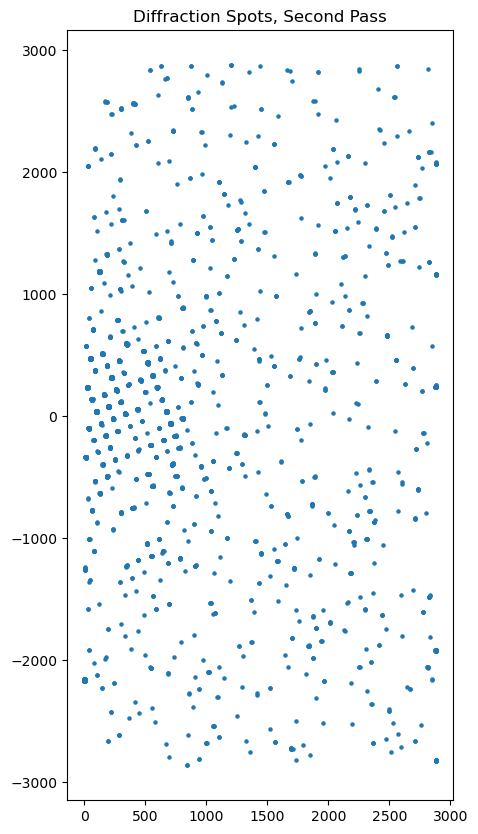

Starting basis: [[-99  40]
 [ 37  99]]
Starting basis size: 22571
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.50810358067031
[40 99] is larger than [-99  37]
The updated basis vectors are [-59 136][-99  37]
This run resulted in a basis larger than the last: 33147
Terminating loop.
------------------------------------


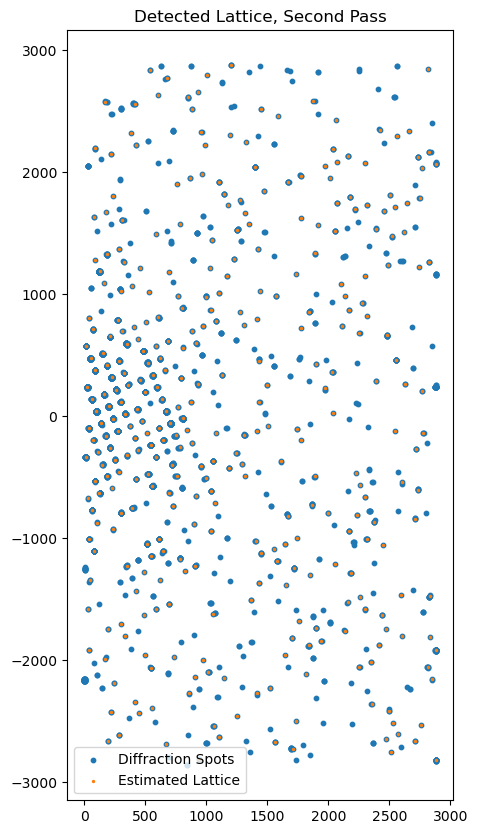

Starting basis: [[-99  40]
 [ 37  99]]
Refined_basis: [[-99.01251685  40.00388237]
 [ 37.02470857  98.97796985]]
Unit cell dimensions (A): 57.1 56.54
Highest resolution spot (A): 1.5


In [55]:
diffraction_indices, highest_resolution, unit_cell_dimensions = find_lattice_secondpass(new_indices,
                        basis,
                        pixel_size,          
                        min_lattice_size=5,
                        epsilon=0.0707,
                        mask_along_lattice=True,
                        show_plots=True,
                        verbose=True)

In [50]:
diffraction_indices.shape

(2, 3246)

In [56]:
# So we can use find_lattice_secondpass to either filter off points that don't belong to the basis,
# or just to calculate some statistics. Either way, we now want to wrap the points and pass them to
# replace_diffraction_spots

masked_fft = sax.replace_diffraction_spots(padded_fft, new_indices, replace_angle)

# Next steps: re-write saxtal_functions.py

In [57]:
# Perform the inverse FFT
padded_masked_image = sax.scipy_inverse_fft(masked_fft, verbose, threads)
# Extract the original image from the padded inverse FFT
masked_image = sax.unpad_image(padded_masked_image, image.shape)
# Export the image as an .mrc file
sax.export_masked_mrc(masked_image, filename_out, verbose)
# Print a message to indicate successful masking
if verbose:
    print(filename + " masked as " + filename_out + " without lattice-finding.")

scipy_ifft(): iFFT performed in 72.41 milliseconds.
Export complete!
test_data/test_lattice.mrc masked as test_data/test_lattice_masked.mrc without lattice-finding.


In [19]:
# ----------------------------------------------------------------------------------------------------------------#

In [20]:
# Wrap points to return to mask_image
# nonredundant_lattice = sax.wrap_indices(nonredundant_lattice, log_diff_spectrum)

In [21]:
# Just out of curiosity, what would happen if we just filtered these points and left the rest?

# Result: it's actually not too bad. The brightest spots are gone, 
# but BK script removes general bright spots as well.

# nonredundant_lattice = sax.wrap_indices(nonredundant_lattice, log_diff_spectrum)

# # Replace the diffraction spots
# masked_fft = sax.replace_diffraction_spots(padded_fft, np.transpose(indices), smoothed_spectrum, replace_angle)
# # Perform the inverse FFT
# padded_masked_image = sax.scipy_inverse_fft(masked_fft, verbose, threads)
# # Extract the original image from the padded inverse FFT
# masked_image = sax.unpad_image(padded_masked_image, image.shape)
# # Export the image as an .mrc file
# sax.export_masked_mrc(masked_image, filename_out, verbose)
# # Print a message to indicate successful masking
# if verbose:
#     print(filename + " masked as " + filename_out + " without lattice-finding.")